# Multi-Modal Conversational Agent with ReAct Prompting

In this tutorial, we will demonstrate how we can utilize a [4B Phi3.5 Vision model](microsoft/Phi-3.5-vision-instruct) to perform multi-step reasoning with tools, to answer Open-Domain questions.

To get both images and posts, we will use a simple Intel related data, taken from wikipedia. We will also include some additional images, to supplement our image data.

This tutorial is based on this [original haystack tutorial](https://haystack.deepset.ai/tutorials/25_customizing_agent).

All assets for this tutorial are available in the [official fastRAG repository](https://github.com/IntelLabs/fastRAG).

In [1]:
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

First, lets load some multi-modal data:

In [2]:
import json
entries = json.load(open("../assets/multi_modal_files/intel_image_data.json", "r"))

Each entry contains a brief textual description, with a title and an image.

Next, we create an index for the documents above.

Lets proceed to our Document Retrieval Pipeline.
It will consist of a retriever to fetch the inital batch, and a prompt builder to formulate the information for our model to use.

In [3]:
document_store = InMemoryDocumentStore()

In [4]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from fastrag.prompt_builders.multi_modal_prompt_builder import MultiModalPromptBuilder
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

template = "{% for document in documents %}\nImage: <|image_\nThis image shows: {{ document.content }} \n{% endfor %}"

retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
retrieval_pipeline.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k=1))
retrieval_pipeline.add_component("prompt_builder", MultiModalPromptBuilder(template=template))

retrieval_pipeline.connect("embedder.embedding", "retriever.query_embedding")
retrieval_pipeline.connect("retriever", "prompt_builder.documents")
print(f"LLM pipeline created")

LLM pipeline created


We create our document tool:

In [5]:
from fastrag.agents.tools.tools import DocWithImageHaystackQueryTool

In [6]:
doc_tool = DocWithImageHaystackQueryTool(
    name="docRetriever",
    description="useful for when you need to retrieve textual documents to answer questions.",
    pipeline_or_yaml_file=retrieval_pipeline
)

To allow our tool to index our pipeline, we provide ```index_pipeline```, that will embed our documents:

In [7]:
from haystack.components.writers import DocumentWriter

In [8]:
index_pipeline = Pipeline()
index_pipeline.add_component(
    instance=SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"), name="doc_embedder"
)
index_pipeline.add_component(
    instance=DocumentWriter(document_store=document_store), name="doc_writer"
)

index_pipeline.connect("doc_embedder.documents", "doc_writer.documents")

🚅 Components
  - doc_embedder: SentenceTransformersDocumentEmbedder
  - doc_writer: DocumentWriter
🛤️ Connections
  - doc_embedder.documents -> doc_writer.documents (List[Document])

With our indexing pipeline ready, we can upload the content:

In [9]:
index_pipeline.run({
    "documents": [
        Document(
            content=entry["content"], 
            meta={
                "title": entry["title"],
                "image_url": entry["image_url"]
            }
        ) for entry in entries
    ]
})

  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'doc_writer': {'documents_written': 3}}

Lets test it out:

In [10]:
query = "Where are Intel's headquarters?"
rag_res = doc_tool.run(query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
print(rag_res[0])


Image: <|image_
This image shows: Headquarters in Santa Clara, California, in 2023 



Notice that we have the "<|image_" placeholder for our model to inject the images into later on.

To orchestrate the usage of all our tools, we will also create a tools manager: 

In [12]:
from fastrag.agents.base import ToolsManager

tools_manager=ToolsManager(tools=[doc_tool])

With the tools manager ready, we create our conversational agent.
For more information about the AGENT_PROMPT and resolver functions, we refer to the [original haystack tutorial](https://haystack.deepset.ai/tutorials/25_customizing_agent).

In [13]:
from fastrag.agents.create_agent import AGENT_ROLES

Now we will load our multi-modal generator:

In [14]:
from fastrag.generators.stopping_criteria.stop_words import StopWordsByTextCriteria
from transformers import AutoTokenizer, StoppingCriteriaList

In [15]:
model_name_or_path = "microsoft/Phi-3.5-vision-instruct"

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [17]:
stop_word_list = ["Observation:", "<|end|>"]

In [18]:
sw = StopWordsByTextCriteria(
    tokenizer=tokenizer, stop_words=stop_word_list, device="cpu"
)

In [19]:
from fastrag.generators.llava import Phi35VisionHFGenerator
import torch

generator = Phi35VisionHFGenerator(
    model = model_name_or_path,
    task = "image-to-text",
    generation_kwargs = {
        "max_new_tokens": 100,
        "stopping_criteria": StoppingCriteriaList([sw])
    },
    huggingface_pipeline_kwargs={
        "torch_dtype": torch.bfloat16,
        "trust_remote_code": True,
        "_attn_implementation": "eager"
    },
)

  warnings.warn(


In [20]:
generator.warm_up()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

With our tools and generator ready, we create our agent:

In [21]:
from fastrag.agents.base import Agent

In [22]:
from fastrag.agents.create_agent import ConversationMemory

In [24]:
conversational_agent = Agent(
    generator,
    prompt_template=AGENT_ROLES,
    tools_manager=tools_manager,
    memory=ConversationMemory(generator=generator),
)

Lets start chatting to our model!

We can start by asking the model a question about an image.

In [25]:
agent_res = conversational_agent.run("Give me an image of headquarters. What is the color of the building?")


Agent Agent started with {'query': 'Give me an image of headquarters. What is the color of the building?', 'params': None}


Both `max_new_tokens` (=100) and `max_length`(=32000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
You are not running the flash-attention implementation, expect numerical differences.


Thought: I should use a tool to help me answer the question.
Tool: docRetriever.
Tool Input: 
```
{
 "input": "image of headquarters"
}
```
Observation:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Observation: 
Image: <|image_
This image shows: Headquarters in Santa Clara, California, in 2023 

Thought: 

Both `max_new_tokens` (=100) and `max_length`(=32000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Final Answer: The headquarters is a modern building with a predominantly blue and white color scheme.<|end|>


Lets look at the image found for us:

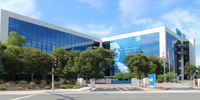

In [26]:
from PIL import Image
import base64
import io

additional_params = conversational_agent.memory.get_additional_params()
image_base64 = additional_params["images"][0]
img = Image.open(io.BytesIO(base64.decodebytes(bytes(image_base64, "utf-8"))))
img.resize((200,100))

The answer seems to be on the money :)

Now, what the model will do if we ask another question about the retrived passage:

In [27]:
agent_res_next = conversational_agent.run("Where are the headquarters located?")


Agent Agent started with {'query': 'Where are the headquarters located?', 'params': None}


Both `max_new_tokens` (=100) and `max_length`(=32000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Thought: I should use a tool to help me answer the question.
Tool: docRetriever.
Tool Input: 
```
{
 "input": "headquarters location"
}
```
Observation:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Observation: 
Image: <|image_
This image shows: Headquarters in Santa Clara, California, in 2023 

Thought: 

Both `max_new_tokens` (=100) and `max_length`(=32000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Final Answer: The headquarters is located in Santa Clara, California.<|end|>


Correct!

Hopefully this gives you an idea of what these types of systems can accomplish, by combining both image and textual data to answer multi-faceted questions. 

Happy coding! :)